In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [16]:
def lorenz(t, x, sigma=10, beta=2.66667, rho=28):
    return [
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2],
    ]

In [17]:
#Generate training data
dt = 0.001
t_train = np.arange(0, 100, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)

In [18]:
poly_order = 2
threshold = 0.05
t_sim = np.arange(0, 20, dt)
optimizer = ps.STLSQ(threshold=0.05)

#Finite difference derivatives.
differentiation_method = ps.FiniteDifference()

model = ps.SINDy(optimizer=optimizer,
                     differentiation_method=differentiation_method,
                     feature_library=ps.PolynomialLibrary(degree=poly_order),
                     discrete_time=False)
model.fit(x_train,t=dt, x_dot=x_dot_train_measured, quiet=True)
model.print()
x_test = model.simulate(x_train[0], t_sim)

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


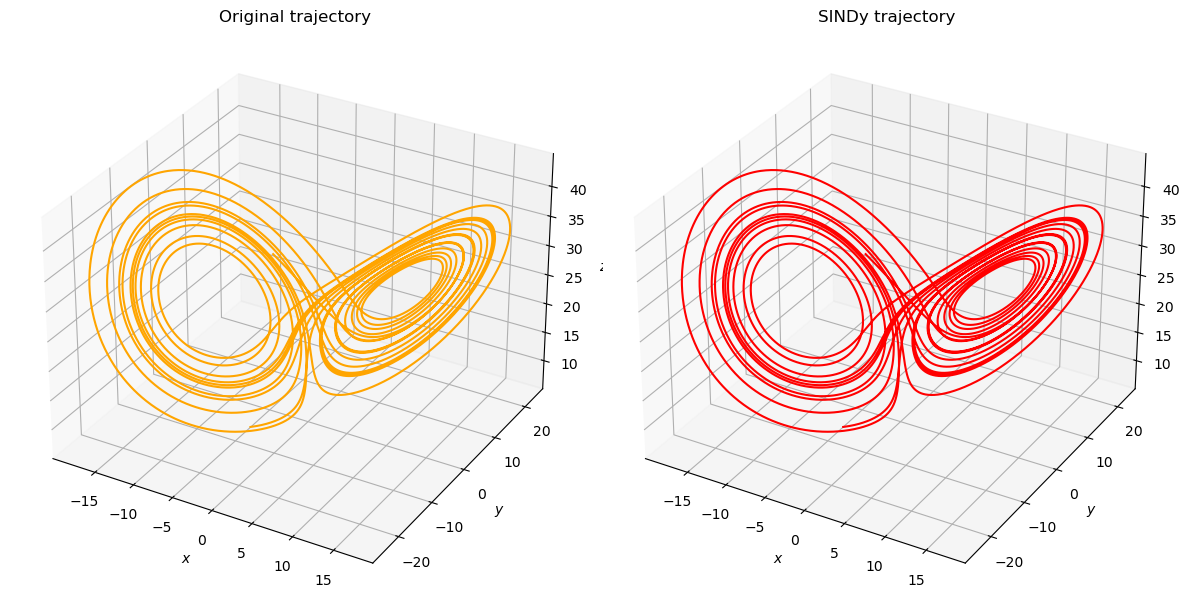

In [33]:
fig = plt.figure(figsize=(12, 6))

#plot original trajectory
ax = fig.add_subplot(121, projection="3d")

x = x_train[: t_sim.size, 0]
y = x_train[: t_sim.size, 1]
z = x_train[: t_sim.size, 2]


ax.plot(x,y,z,color="orange")
ax.set_title("Original trajectory")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")


#plot SINDy trajectory
ax = fig.add_subplot(122, projection="3d")

x_calc = x_test[: t_sim.size, 0]
y_calc = x_test[: t_sim.size, 1]
z_calc = x_test[: t_sim.size, 2]

ax.plot(x_calc,y_calc,z_calc,color = "red")
ax.set_title("SINDy trajectory")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

plt.tight_layout()
plt.show()

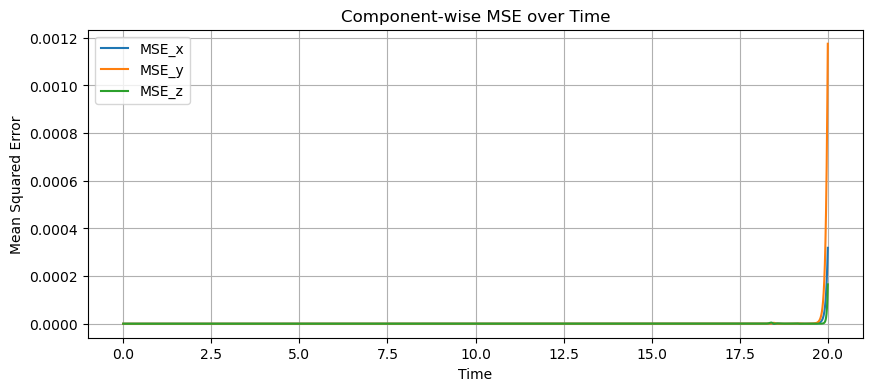

In [22]:
fig = plt.figure(figsize=(9,5))


MSE_x = (x-x_calc)**2 
MSE_y = (y-y_calc)**2
MSE_z = (z-z_calc)**2

plt.plot(t_sim, MSE_x, label='MSE_x')
plt.plot(t_sim, MSE_y, label='MSE_y')
plt.plot(t_sim, MSE_z, label='MSE_z')

plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.title('Component-wise MSE over Time')
plt.legend()
plt.grid(True)
plt.show()

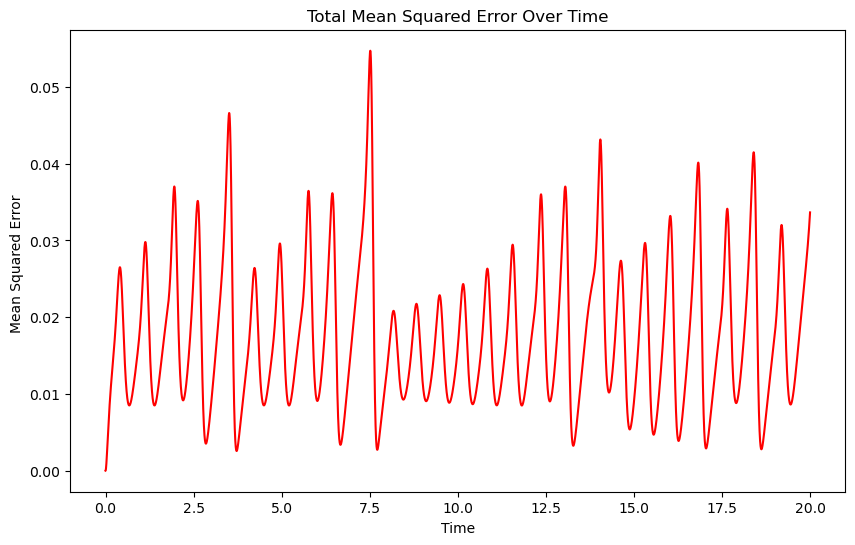

In [7]:
plt.figure(figsize=(10,6))
SE = []
for i, x in enumerate(x_test): 
    SE.append((np.sum((x - x_train[: t_sim.size]) ** 2, axis=1)))
SE = np.asarray(SE)
MSE = SE/x_test.shape[0]
MSE
plt.plot(t_sim,MSE[1,:], color="red")
plt.xlabel("Time")
plt.ylabel("Mean Squared Error ")
plt.title("Total Mean Squared Error Over Time")
plt.show()


In [39]:
# Fit the models and simulate with noise
noise_levels = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]

models = []
t_sim = np.arange(0, 20, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))
    
for model in models: 
    model.print()

(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1
(x0)' = -9.998 x0 + 9.999 x1
(x1)' = 28.004 x0 + -1.001 x1 + -1.000 x0 x2
(x2)' = -2.667 x2 + 1.000 x0 x1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


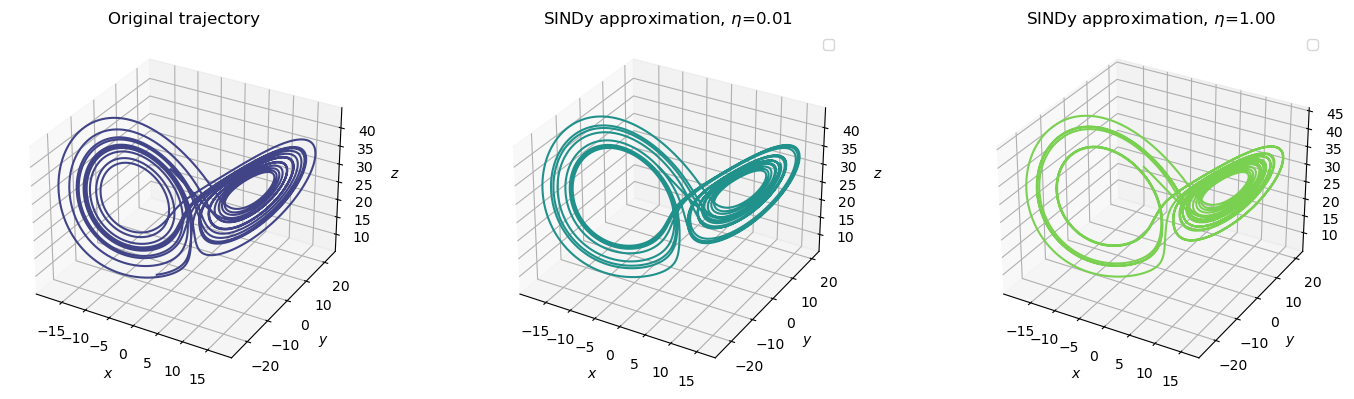

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Define a colormap
cmap = plt.get_cmap("viridis")

# Plot results
fig = plt.figure(figsize=(15, 4))

# Subplot 1
ax = fig.add_subplot(131, projection="3d")
ax.plot(
    x_train[: t_sim.size, 0],
    x_train[: t_sim.size, 1],
    x_train[: t_sim.size, 2],
    color=cmap(0.2),  # Assign color based on noise level
)
ax.set_title("Original trajectory")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")

# Subplot 2
model_idx = 2
ax = fig.add_subplot(132, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2], color=cmap(0.5))
ax.set_title(f"SINDy approximation, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
ax.legend()

# Subplot 3
model_idx = 4
ax = fig.add_subplot(133, projection="3d")
ax.plot(x_sim[model_idx][:, 0], x_sim[model_idx][:, 1], x_sim[model_idx][:, 2], color=cmap(0.8))
ax.set_title(f"SINDy approximation, $\eta$={noise_levels[model_idx]:.2f}")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
ax.legend()

plt.tight_layout()
plt.show()


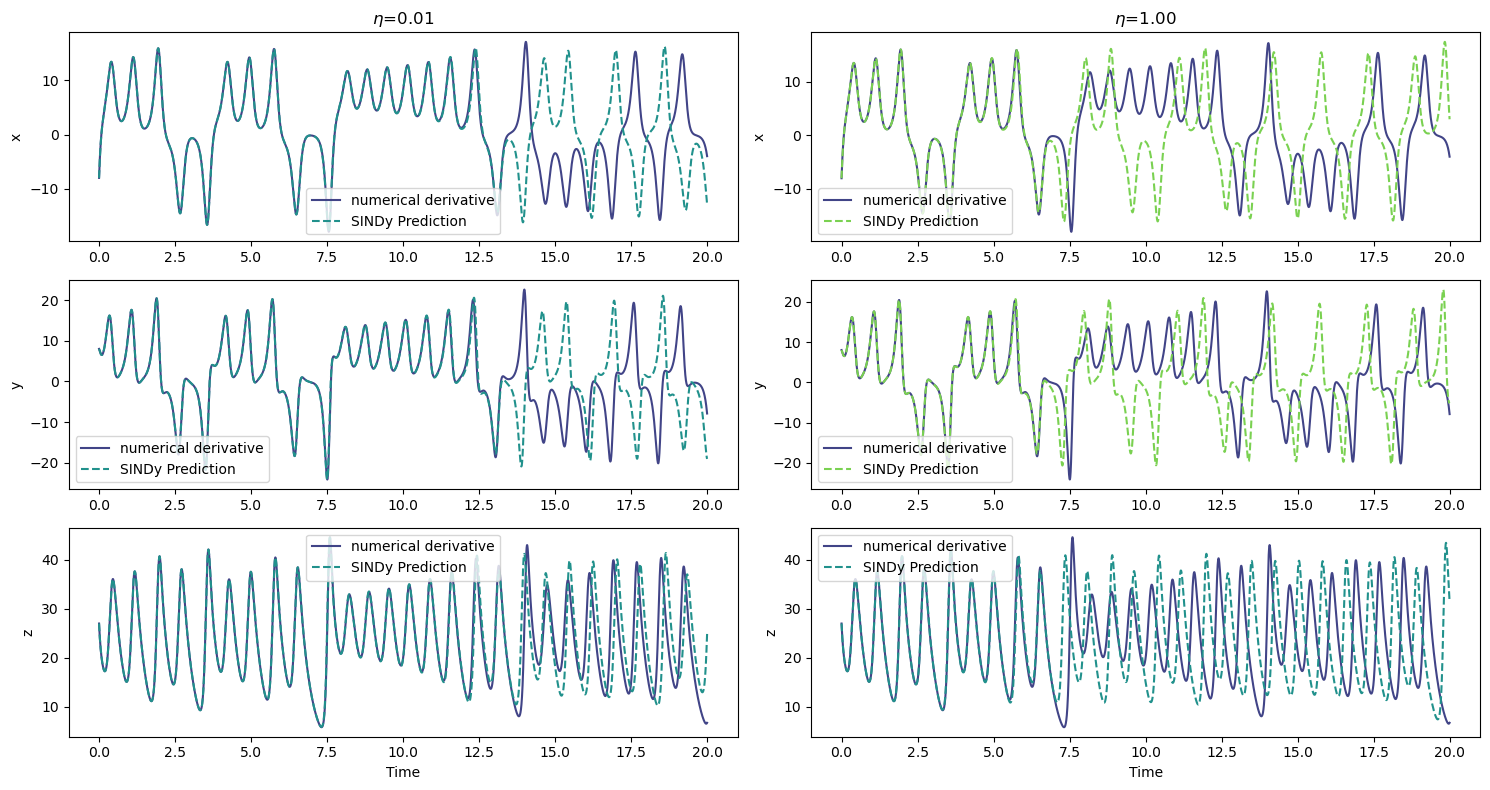

In [10]:
fig = plt.figure(figsize=(15, 8))

# Subplot 1
model_idx = 2
ax = fig.add_subplot(321)
ax.plot(t_sim, x_train[: t_sim.size, 0], color=cmap(0.2), label = "numerical derivative")
ax.plot(t_sim, x_sim[model_idx][:, 0], color=cmap(0.5), linestyle='--', label="SINDy Prediction")
ax.set_title(f"$\eta$={noise_levels[model_idx]:.2f}")
ax.set_ylabel("x")
ax.legend()

# Subplot 2
ax = fig.add_subplot(323)
ax.plot(t_sim, x_train[: t_sim.size, 1], color=cmap(0.2), label = "numerical derivative")
ax.plot(t_sim, x_sim[model_idx][:, 1], color=cmap(0.5), linestyle='--', label="SINDy Prediction")
#ax.set_xlabel("Time")
ax.set_ylabel("y")
ax.legend()

#subplot 3
ax = fig.add_subplot(325)
ax.plot(t_sim, x_train[: t_sim.size, 2], color=cmap(0.2), label = "numerical derivative")
ax.plot(t_sim, x_sim[model_idx][:, 2], color=cmap(0.5), linestyle='--', label="SINDy Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("z")
ax.legend()


# Subplot 4
model_idx = 4
ax = fig.add_subplot(322)
ax.plot(t_sim, x_train[: t_sim.size, 0], color=cmap(0.2), label = "numerical derivative")
ax.plot(t_sim, x_sim[model_idx][:, 0], color=cmap(0.8), linestyle='--', label="SINDy Prediction")
ax.set_title(f"$\eta$={noise_levels[model_idx]:.2f}")
ax.set_ylabel("x")
ax.legend()

# Subplot 5
ax = fig.add_subplot(324)
ax.plot(t_sim, x_train[: t_sim.size, 1], color=cmap(0.2), label = "numerical derivative")
ax.plot(t_sim, x_sim[model_idx][:, 1], color=cmap(0.8), linestyle='--', label="SINDy Prediction")
#ax.set_xlabel("Time")
ax.set_ylabel("y")
ax.legend()

ax = fig.add_subplot(326)
ax.plot(t_sim, x_train[: t_sim.size, 2], color=cmap(0.2), label = "numerical derivative")
ax.plot(t_sim, x_sim[model_idx][:, 2], color=cmap(0.5), linestyle='--', label="SINDy Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("z")
ax.legend()


plt.tight_layout()
plt.show()

In [11]:
x_sim

[array([[ -8.        ,   8.        ,  27.        ],
        [ -7.84087857,   7.9835534 ,  26.86488244],
        [ -7.68350838,   7.96625063,  26.73151854],
        ...,
        [-12.80260992, -10.9654277 ,  34.51619176],
        [-12.78385861, -10.87084008,  34.56376419],
        [-12.76435081, -10.77587451,  34.60979224]]),
 array([[ -8.        ,   8.        ,  27.        ],
        [ -7.84087857,   7.9835534 ,  26.86488245],
        [ -7.68350838,   7.96625063,  26.73151855],
        ...,
        [-16.60135796, -16.28435584,  38.59590764],
        [-16.59724176, -16.09090244,  38.76147291],
        [-16.59122926, -15.89498142,  38.92328888]]),
 array([[ -8.        ,   8.        ,  27.        ],
        [ -7.84087866,   7.9835535 ,  26.86488241],
        [ -7.68350856,   7.96625083,  26.73151848],
        ...,
        [-12.77413061, -19.00246588,  24.53175112],
        [-12.83622622, -19.02672436,  24.70958448],
        [-12.89793487, -19.04887417,  24.88841796]]),
 array([[-8.       

In [41]:
#models = np.array([models[2], models[4]])
x_sim = np.array([x_sim[2],x_sim[4]])

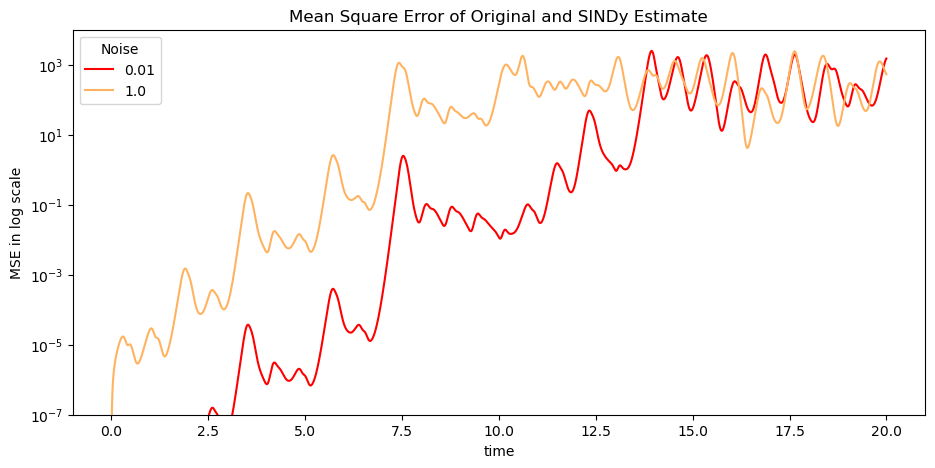

In [42]:
noise_levels = [1e-2, 1.0]
colors = rainbow(np.linspace(1, 0, len(models)))

fig, ax = plt.subplots(figsize=(11, 5))  # Create a single plot

for i, x in enumerate(x_sim):
    ax.semilogy(
        t_sim,
        np.sum((x - x_train[: t_sim.size]) ** 2, axis=1),
        color=colors[i],
        label=noise_levels[i],
    )

ax.set(xlabel="time", title="Mean Square Error of Original and SINDy Estimate")
ax.set(ylabel="MSE in log scale")
ax.legend(title="Noise")
ax.set_ylim(1e-7, 1e4)
plt.show()  # Display the plot